# Pasture Biomass Estimation (Tabular & Computer Vision)

This notebook covers the data processing, analysis, and modeling for pasture biomass estimation using both tabular data (LightGBM) and images (CNN with PyTorch).

## 1. Environment Setup & Imports

In [78]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Machine Learning
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
pd.set_option('display.max_columns', None)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading & Preprocessing
We convert the data from a long format (one target per row) to a wide format (one image per row).

In [79]:
# Load Data
df = pd.read_csv('./data/biomass/train.csv')

# Initial checks
print("Unique samples:", df['sample_id'].nunique())
print(df["target_name"].value_counts())
print("\nMissing values:\n", df.isna().sum())

# Split sample_id into image_id and target_name
df["image_id"] = df["sample_id"].str.split("__").str[0]
df["target_name"] = df["sample_id"].str.split("__").str[1]

# Create Features DataFrame (deduplicated by image)
df_features = (
    df[
        ["image_id", "Sampling_Date", "State", "Species", 
         "Pre_GSHH_NDVI", "Height_Ave_cm"]
    ]
    .drop_duplicates("image_id")
)

# Create Targets DataFrame (Pivot to wide format)
df_targets = (
    df[["image_id", "target_name", "target"]]
    .pivot(index="image_id", columns="target_name", values="target")
    .reset_index()
)

# Merge features and targets
df_wide = df_features.merge(df_targets, on="image_id", how="inner")

# Define target columns
targets = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

# Wide dataframe checks
print("Shape:", df_wide.shape)
print("Duplicated images:", df_wide.duplicated(subset="image_id").sum())
df_wide.head()

Unique samples: 1785
target_name
Dry_Clover_g    357
Dry_Dead_g      357
Dry_Green_g     357
Dry_Total_g     357
GDM_g           357
Name: count, dtype: int64

Missing values:
 sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64
Shape: (357, 11)
Duplicated images: 0


,image_id,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


## 3. Exploratory Data Analysis (EDA)

               count       mean        std   min      25%      50%      75%  \
Pre_GSHH_NDVI  357.0   0.657423   0.152142  0.16   0.5600   0.6900   0.7700   
Height_Ave_cm  357.0   7.595985  10.285262  1.00   3.0000   4.0000   7.0000   
Dry_Clover_g   357.0   6.649692  12.117761  0.00   0.0000   1.4235   7.2429   
Dry_Dead_g     357.0  12.044548  12.402007  0.00   3.2000   7.9809  17.6378   
Dry_Green_g    357.0  26.624722  25.401232  0.00   8.8000  20.8000  35.0834   
Dry_Total_g    357.0  45.318097  27.984015  1.04  25.2715  40.3000  57.8800   
GDM_g          357.0  33.274414  24.935822  1.04  16.0261  27.1082  43.6757   

                    max  
Pre_GSHH_NDVI    0.9100  
Height_Ave_cm   70.0000  
Dry_Clover_g    71.7865  
Dry_Dead_g      83.8407  
Dry_Green_g    157.9836  
Dry_Total_g    185.7000  
GDM_g          157.9836  


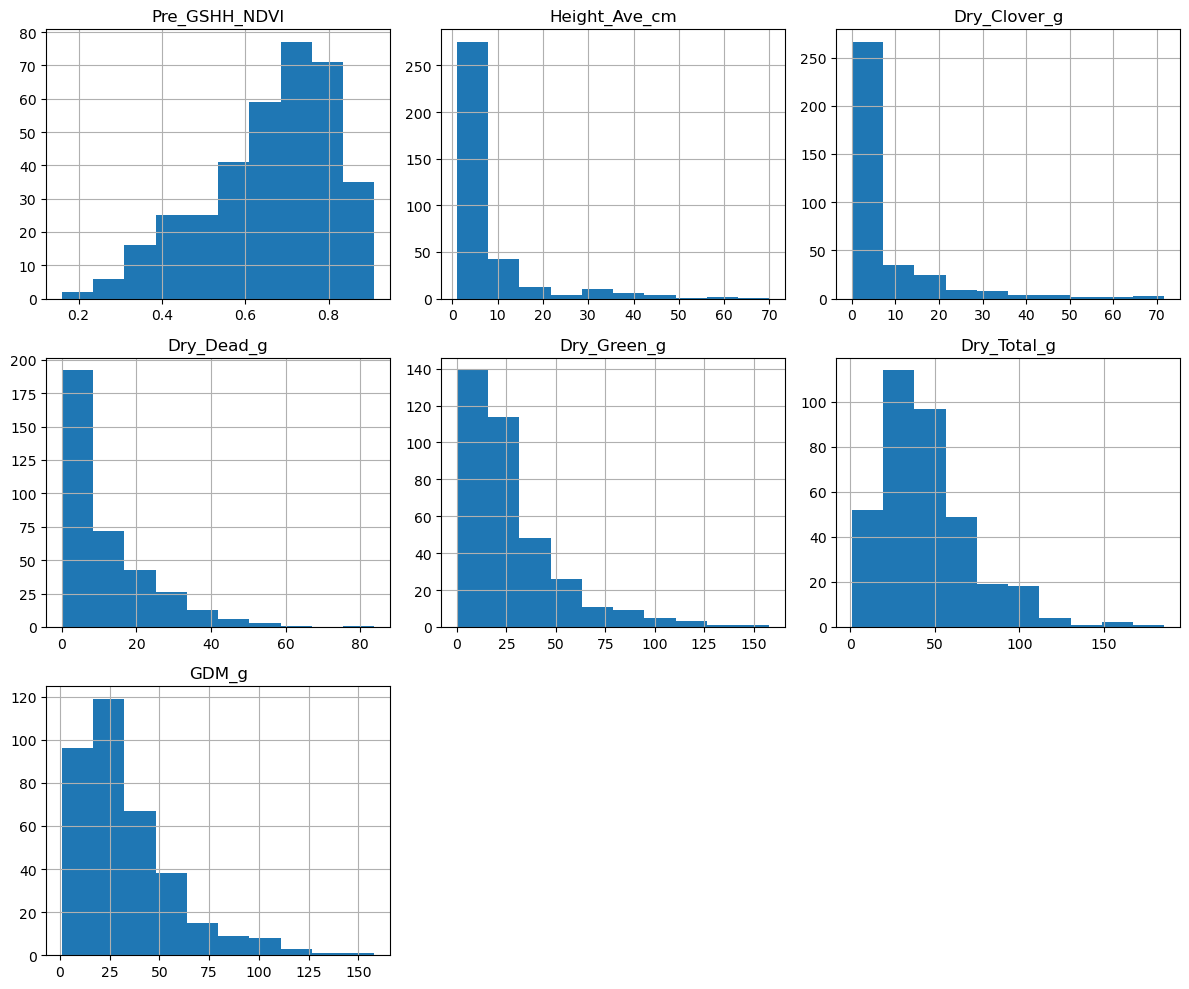

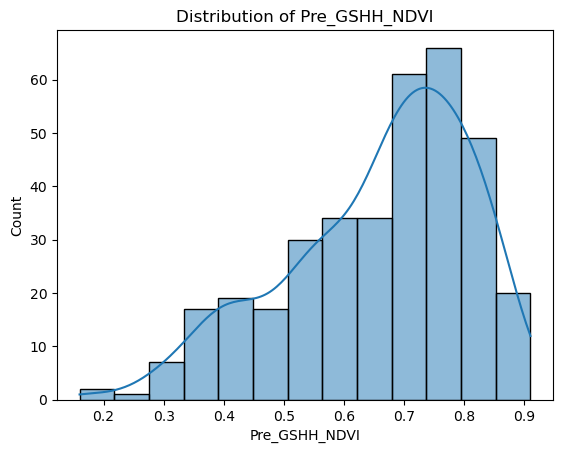

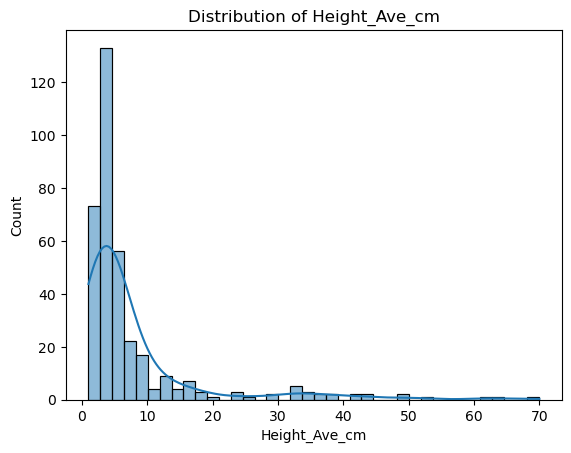

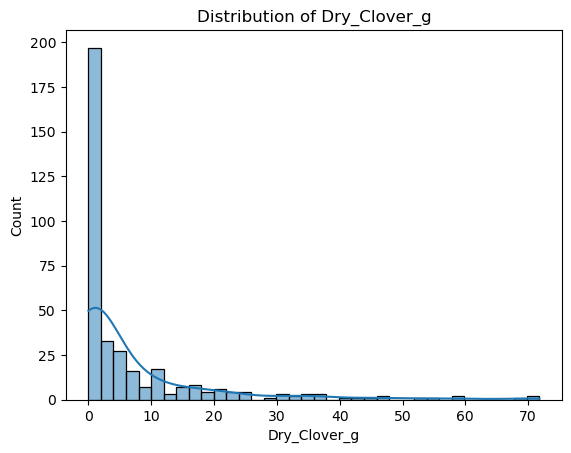

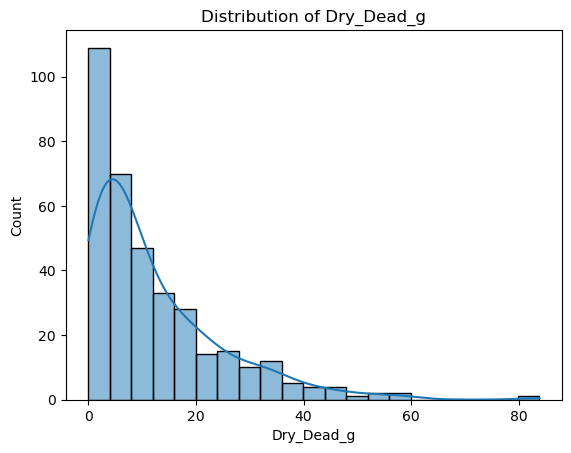

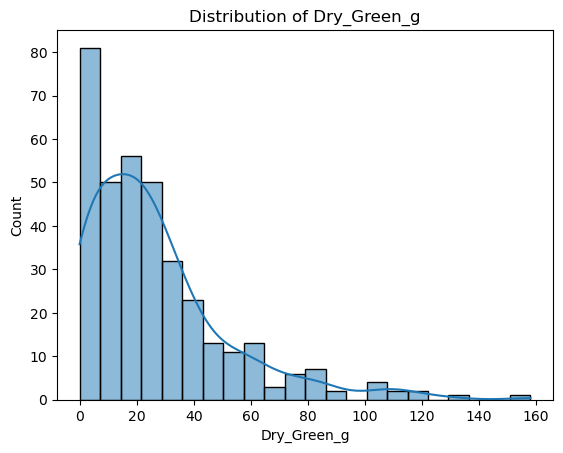

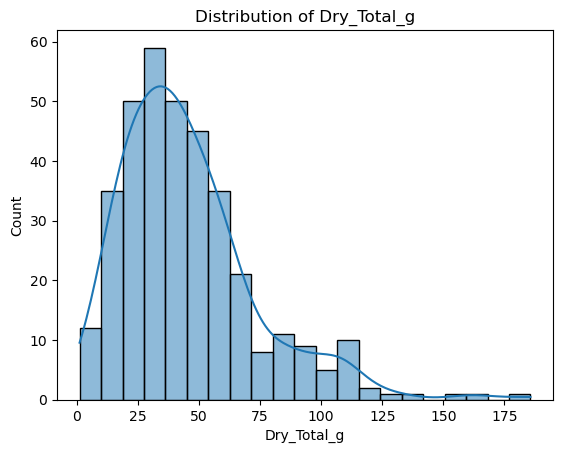

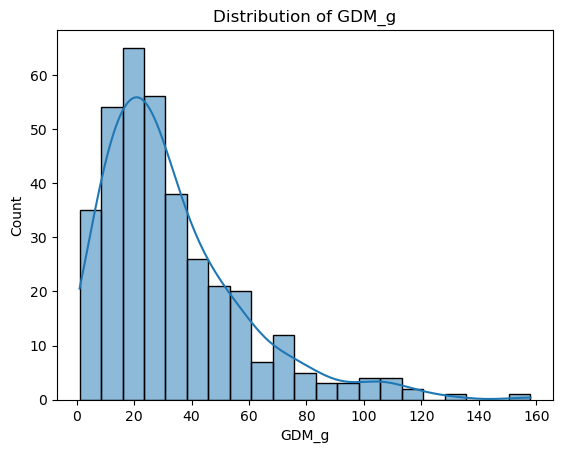

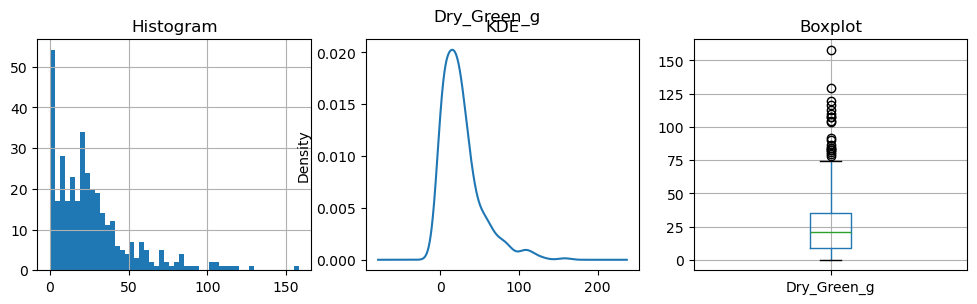

Dry_Green_g zeros_pct: 0.05042016806722689 skew: 1.7514455052189946


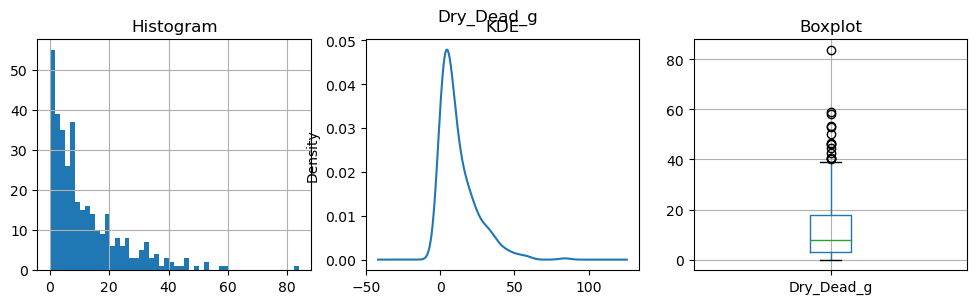

Dry_Dead_g zeros_pct: 0.11204481792717087 skew: 1.7613667806611064


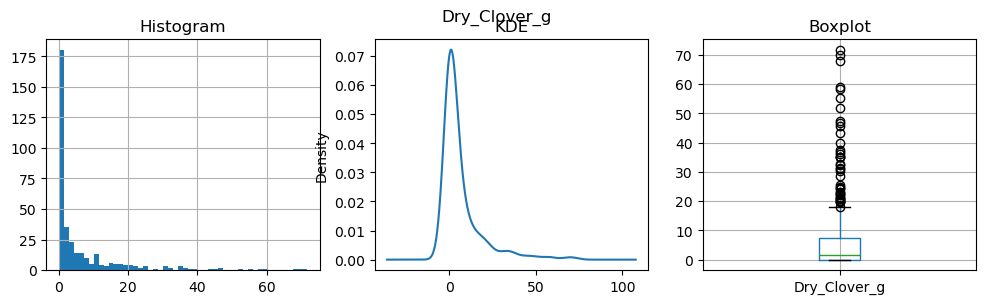

Dry_Clover_g zeros_pct: 0.37815126050420167 skew: 2.841982362787661


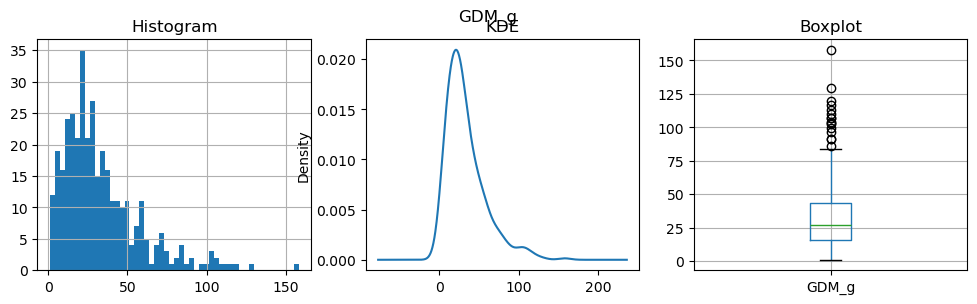

GDM_g zeros_pct: 0.0 skew: 1.5590328001560023


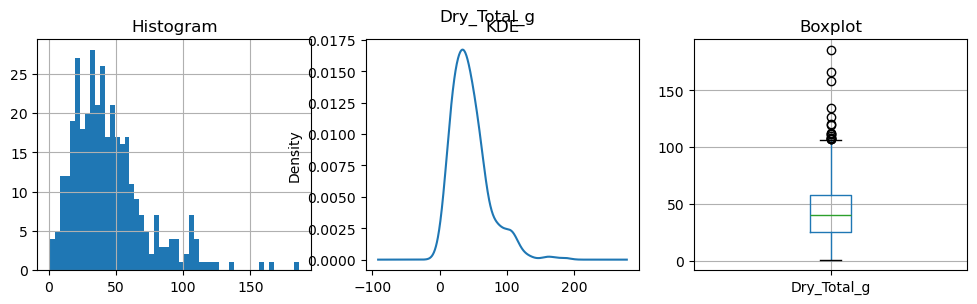

Dry_Total_g zeros_pct: 0.0 skew: 1.4285259267259003


In [80]:
# Basic Statistics
print(df_wide.describe().T)

# Histograms for all columns
df_wide.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Distribution plots per column
for column in df_wide.drop(columns=['image_id', 'Sampling_Date', 'State', 'Species']).columns:
    if column in df_wide.select_dtypes(include=np.number).columns:
        sns.histplot(df_wide[column], kde=True)
        plt.title(f"Distribution of {column}")
        plt.show()
        plt.close()

# Detailed Target Analysis
for t in targets:
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    df_wide[t].hist(ax=ax[0], bins=50)
    ax[0].set_title("Histogram")
    
    df_wide[t].plot(kind="kde", ax=ax[1])
    ax[1].set_title("KDE")
    
    df_wide.boxplot(column=t, ax=ax[2])
    ax[2].set_title("Boxplot")
    
    plt.suptitle(t)
    plt.show()
    print(t, "zeros_pct:", (df_wide[t] == 0).mean(), "skew:", df_wide[t].skew())

              Dry_Green_g  Dry_Dead_g  Dry_Clover_g     GDM_g  Dry_Total_g
Dry_Green_g      1.000000    0.095554     -0.276582  0.884257     0.830315
Dry_Dead_g       0.095554    1.000000     -0.175548  0.012028     0.453912
Dry_Clover_g    -0.276582   -0.175548      1.000000  0.204213     0.104185
GDM_g            0.884257    0.012028      0.204213  1.000000     0.896441
Dry_Total_g      0.830315    0.453912      0.104185  0.896441     1.000000


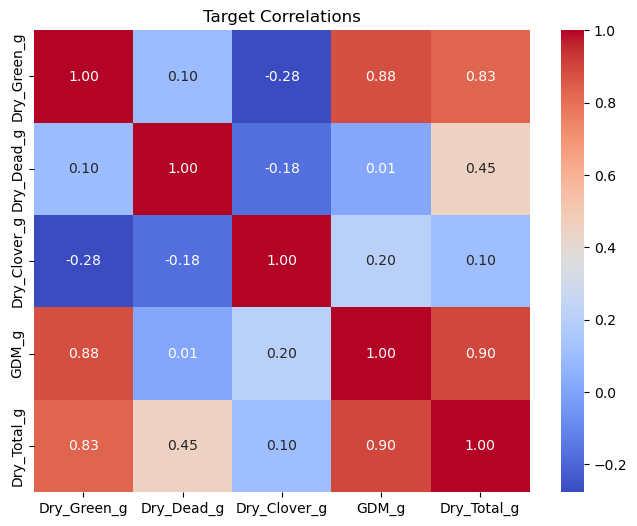

Correlation Pre_GSHH_NDVI vs Dry_Green_g: 0.3511


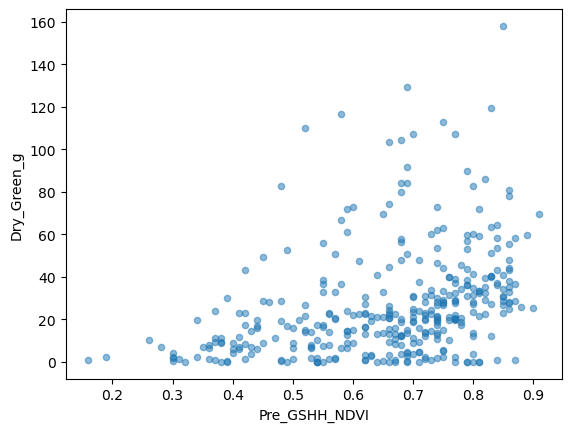

Correlation Pre_GSHH_NDVI vs Dry_Dead_g: -0.1228


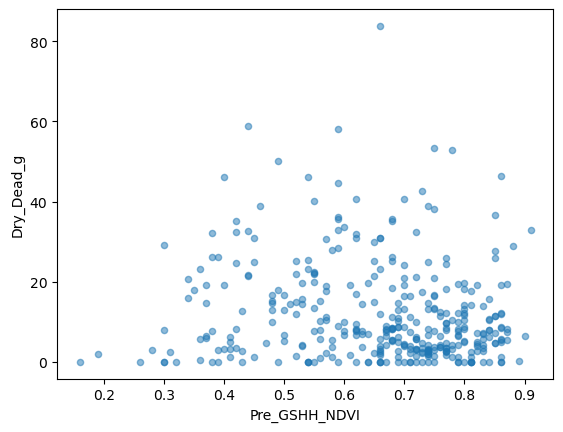

Correlation Pre_GSHH_NDVI vs Dry_Clover_g: 0.2242


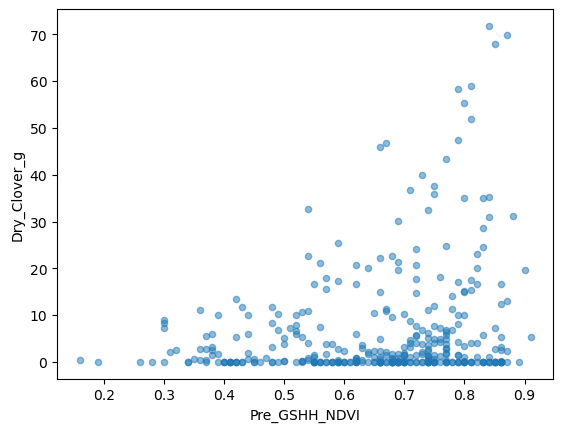

Correlation Pre_GSHH_NDVI vs GDM_g: 0.4665


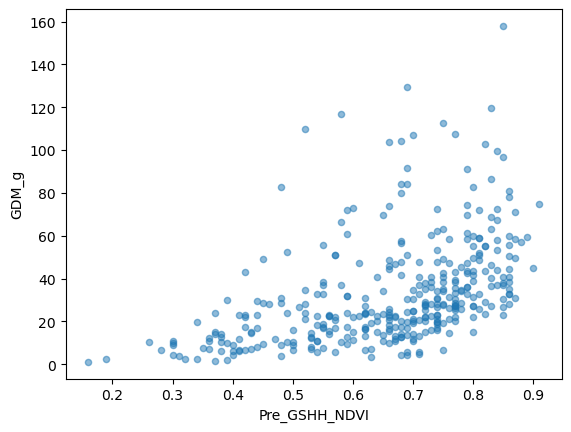

Correlation Pre_GSHH_NDVI vs Dry_Total_g: 0.3613


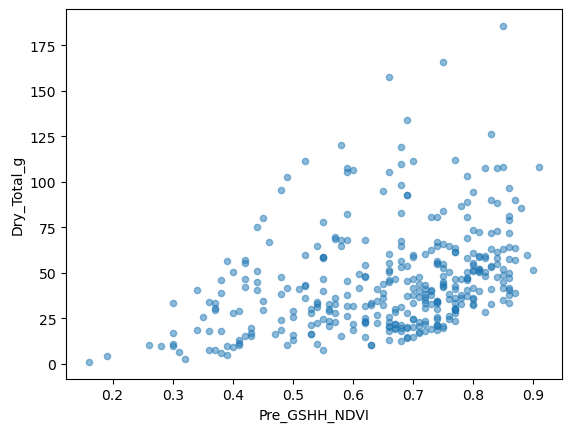

Correlation Height_Ave_cm vs Dry_Green_g: 0.6484


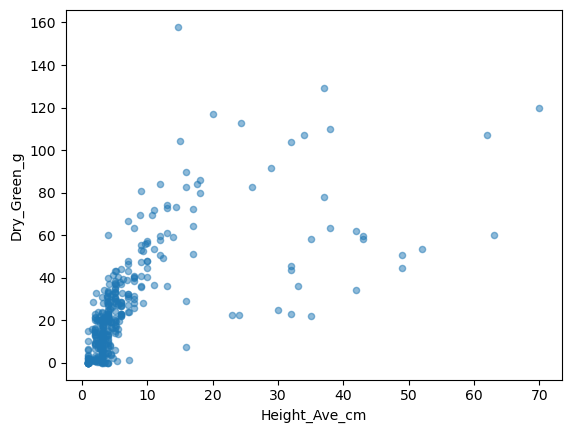

Correlation Height_Ave_cm vs Dry_Dead_g: -0.0497


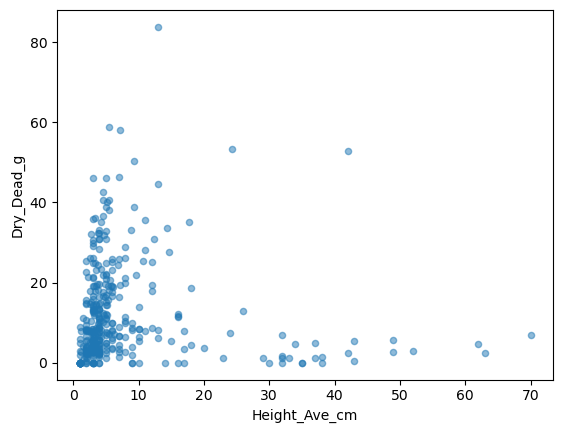

Correlation Height_Ave_cm vs Dry_Clover_g: -0.1601


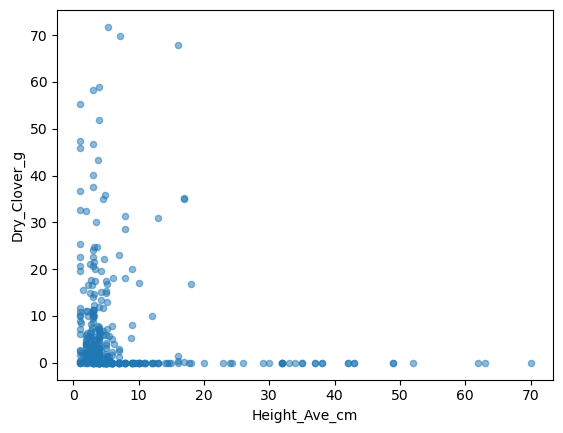

Correlation Height_Ave_cm vs GDM_g: 0.5827


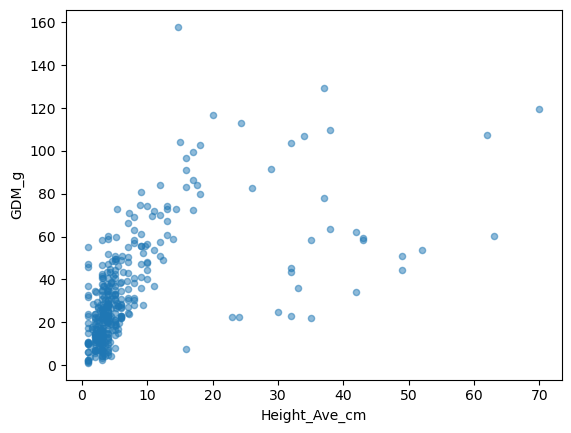

Correlation Height_Ave_cm vs Dry_Total_g: 0.4972


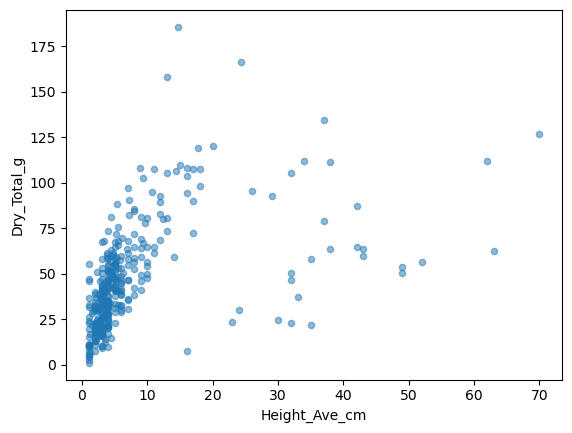

In [81]:
# Correlation Matrix
corr = df_wide[targets].corr()
print(corr)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Target Correlations")
plt.show()

# Numerical Features vs Targets
num_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
for f in num_feats:
    for t in targets:
        correlation = df_wide[[f, t]].corr().iloc[0, 1]
        print(f"Correlation {f} vs {t}: {correlation:.4f}")
        df_wide.plot.scatter(x=f, y=t, alpha=0.5)
        plt.show()

### Data Consistency Check
Verifying that the total biomass equals the sum of its components.

In [82]:
# Check if components sum up to total
df_wide["sum_components"] = df_wide["Dry_Green_g"] + df_wide["Dry_Dead_g"] + df_wide["Dry_Clover_g"]
df_wide["error_total"] = df_wide["Dry_Total_g"] - df_wide["sum_components"]

print("Error description (should be near 0):")
print(df_wide["error_total"].describe())

# Note: Dry_Total_g is always the sum of the other columns, so it can be discarded during training if needed.

Error description (should be near 0):
count    357.000000
mean      -0.000866
std        0.016343
min       -0.308800
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000100
Name: error_total, dtype: float64


## 4. Feature Engineering & Split

In [83]:
# 1. Multilabel encoding for Species
species_split = df_wide["Species"].str.split("_")
unique_sp = sorted({s for row in species_split for s in row})

for s in unique_sp:
    df_wide["sp_" + s] = df_wide["Species"].apply(lambda x: int(s in x.split("_")))

# 2. Define Feature Lists
NUM_FEATS = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
CAT_FEATS = ["State"]
SPECIES_FEATS = [c for c in df_wide.columns if c.startswith("sp_")]
ALL_FEATS = NUM_FEATS + SPECIES_FEATS # State will be one-hot encoded separately

# 3. Create Folds (GroupKFold by State)
n_groups = df_wide["State"].nunique()
gkf = GroupKFold(n_splits=n_groups)

df_wide["fold"] = -1
for f, (tr, val) in enumerate(gkf.split(df_wide, groups=df_wide["State"])):
    df_wide.loc[val, "fold"] = f

print("Samples per fold:")
print(df_wide["fold"].value_counts())
print("States per fold:")
print(df_wide.groupby("fold")["State"].nunique())

Samples per fold:
fold
0    138
1    112
2     75
3     32
Name: count, dtype: int64
States per fold:
fold
0    1
1    1
2    1
3    1
Name: State, dtype: int64


## 5. Model 1: LightGBM (Tabular)

In [84]:
# Prepare Data for LightGBM
df_model = df_wide.copy()

# One-hot encoding for 'State'
df_model = pd.get_dummies(df_model, columns=["State"], drop_first=True)

# Update feature list after One-Hot Encoding
features_lgb = [
    "Pre_GSHH_NDVI", "Height_Ave_cm",
    "sp_Mixed", "sp_Phalaris", "sp_Ryegrass", 
    "sp_SilverGrass", "sp_SpearGrass", 
    "sp_SubcloverDalkeith", "sp_SubcloverLosa", "sp_WhiteClover"
]
# Note: Add any one-hot encoded state columns to features_lgb if you wish to use them.

# Scale Numerical Features
scaler = StandardScaler()
df_model[NUM_FEATS] = scaler.fit_transform(df_model[NUM_FEATS])
joblib.dump(scaler, "scaler_tabular.pkl")

# Training Loop
oof = np.zeros((len(df_model), len(targets)))

for i, tgt in enumerate(targets):
    print(f"\n{'='*30}")
    print(f"Training target: {tgt}")
    
    for f in sorted(df_model.fold.unique()):
        tr_idx = df_model.fold != f
        val_idx = df_model.fold == f

        X_tr  = df_model.loc[tr_idx, features_lgb]
        y_tr  = df_model.loc[tr_idx, tgt]
        X_val = df_model.loc[val_idx, features_lgb]
        y_val = df_model.loc[val_idx, tgt]

        # PROTECTION AGAINST EMPTY FOLDS
        if X_val.shape[0] == 0:
            raise RuntimeError(f"Fold {f} is empty. Check fold assignment.")

        dtrain = lgb.Dataset(X_tr.values, label=y_tr.values)
        dval   = lgb.Dataset(X_val.values, label=y_val.values)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.03,
            "num_leaves": 64,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 1,
            "min_data_in_leaf": 10,
            "verbosity": -1
        }

        callbacks = [
            lgb.early_stopping(150),
            lgb.log_evaluation(200)
        ]

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=5000,
            valid_sets=[dval],
            callbacks=callbacks
        )

        joblib.dump(model, f"lgb_{tgt}_fold{f}.pkl")
        oof[val_idx, i] = model.predict(X_val.values)

# Evaluation
print("\n======== OOF RMSE ========")
for i, tgt in enumerate(targets):
    mse = mean_squared_error(df_model[tgt].values, oof[:, i])
    rmse = mse ** 0.5
    print(f"{tgt}: {rmse:.4f}")



Training target: Dry_Green_g
Training until validation scores don't improve for 150 rounds
[200]	valid_0's rmse: 11.0592
Early stopping, best iteration is:
[126]	valid_0's rmse: 10.7217
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 11.4911
Training until validation scores don't improve for 150 rounds
[200]	valid_0's rmse: 31.1472
Early stopping, best iteration is:
[199]	valid_0's rmse: 31.1217
Training until validation scores don't improve for 150 rounds
[200]	valid_0's rmse: 9.74805
Early stopping, best iteration is:
[127]	valid_0's rmse: 9.24414

Training target: Dry_Dead_g
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 13.2617
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 8.8957
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration 

## 6. Model 2: CNN Regressor (Images)

In [85]:
FOLD = 0 # Seleccionamos un fold para demostración

train_df = df_wide[df_wide.fold != FOLD].reset_index(drop=True)
val_df   = df_wide[df_wide.fold == FOLD].reset_index(drop=True)

target_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

# -------------------------
# OUTLIER HANDLING (solo train)
# -------------------------
def clip_outliers_iqr(df, cols, factor=1.5):
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df[col] = df[col].clip(lower, upper)
    return df

train_df = clip_outliers_iqr(train_df, target_cols)

# -------------------------
# LOG1P TRANSFORM PARA TARGETS SESGADOS
# -------------------------
log_targets = ["Dry_Dead_g", "GDM_g"]

train_df[log_targets] = train_df[log_targets].apply(np.log1p)
val_df[log_targets]   = val_df[log_targets].apply(np.log1p)

# -------------------------
# ESCALADO DE TODOS LOS TARGETS
# -------------------------
scaler_y = StandardScaler()

train_targets = train_df[target_cols].values
val_targets   = val_df[target_cols].values

train_df[target_cols] = scaler_y.fit_transform(train_targets)
val_df[target_cols]   = scaler_y.transform(val_targets)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)


Train shape: (219, 30)
Val shape: (138, 30)


In [97]:
# ===============================================
# 6.2 Dataset & Model Definition (ResNet Version)
# ===============================================

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms, models


# -------------------------
# Transforms (con normalización de ImageNet)
# -------------------------

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# -------------------------
# Dataset Class
# -------------------------

class PastureDataset(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.train = train
        self.tfms = train_tfms if train else val_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Manejo flexible de extensiones o rutas
        img_name = f"{row.image_id}.jpg"
        img_path = os.path.join(self.img_dir, img_name)
        
        img = Image.open(img_path).convert("RGB")
        img = self.tfms(img)

        if self.train:
            y = torch.tensor(
                row[["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]].astype("float32").values,
                dtype=torch.float32
            )
        else:
            # --- FIX: Devolver ceros en lugar de None para evitar error en DataLoader ---
            y = torch.zeros(5, dtype=torch.float32) 

        return img, y



# -------------------------
# ResNet Model (pretrained)
# -------------------------

class ResNetRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        # Backbone preentrenado
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Congelar todo inicialmente
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Descongelar capas más profundas para finetuning
        for name, param in self.backbone.named_parameters():
            if "layer2" in name or "layer3" in name or "layer4" in name:
                param.requires_grad = True

        # Número de features de salida del backbone
        in_features = self.backbone.fc.in_features

        # Nueva cabeza para regresión
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 5)  # 5 targets
        )

    def forward(self, x):
        return self.backbone(x)






In [87]:
# 6.3 Training Loop con validación + Scheduler + Early Stopping

model = ResNetRegressor().to(device)
opt = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

crit = nn.SmoothL1Loss()

train_ds = PastureDataset(train_df, "./data/biomass/train", train=True)
val_ds   = PastureDataset(val_df, "./data/biomass/train", train=False)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

# -----------------------------
# Scheduler + Early Stopping
# -----------------------------
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

scheduler = ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.5,
    patience=3,
)

early_patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

print("Starting training...")
for epoch in range(30):

    # ------------------------
    # TRAIN
    # ------------------------
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        pred = model(x)
        loss = crit(pred, y)
        loss.backward()
        opt.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ------------------------
    # VALIDATION
    # ------------------------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = crit(pred, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # ------------------------
    # Scheduler: adjust LR
    # ------------------------
    scheduler.step(val_loss)

    # ------------------------
    # Early Stopping
    # ------------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

        torch.save(model.state_dict(), "best_cnn_model.pth")
    else:
        epochs_no_improve += 1

    # ------------------------
    # PRINT RESULTS
    # ------------------------
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"No Improve: {epochs_no_improve}"
    )

    if epochs_no_improve >= early_patience:
        print("\nEarly stopping triggered!")
        break


Starting training...
Epoch 01 | Train Loss: 0.5416 | Val Loss: 0.4921 | No Improve: 0
Epoch 02 | Train Loss: 0.5275 | Val Loss: 0.4975 | No Improve: 1
Epoch 03 | Train Loss: 0.5163 | Val Loss: 0.4915 | No Improve: 0
Epoch 04 | Train Loss: 0.5053 | Val Loss: 0.4872 | No Improve: 0
Epoch 05 | Train Loss: 0.4889 | Val Loss: 0.4818 | No Improve: 0
Epoch 06 | Train Loss: 0.4809 | Val Loss: 0.4812 | No Improve: 0
Epoch 07 | Train Loss: 0.4913 | Val Loss: 0.4870 | No Improve: 1
Epoch 08 | Train Loss: 0.4632 | Val Loss: 0.4781 | No Improve: 0
Epoch 09 | Train Loss: 0.4536 | Val Loss: 0.4695 | No Improve: 0
Epoch 10 | Train Loss: 0.4446 | Val Loss: 0.4669 | No Improve: 0
Epoch 11 | Train Loss: 0.4390 | Val Loss: 0.4629 | No Improve: 0
Epoch 12 | Train Loss: 0.4257 | Val Loss: 0.4573 | No Improve: 0
Epoch 13 | Train Loss: 0.4470 | Val Loss: 0.4666 | No Improve: 1
Epoch 14 | Train Loss: 0.4019 | Val Loss: 0.4563 | No Improve: 0
Epoch 15 | Train Loss: 0.4246 | Val Loss: 0.4520 | No Improve: 0
Epoc

In [88]:
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        all_preds.append(pred.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Stack results
y_pred = np.vstack(all_preds)
y_true = np.vstack(all_targets)

# Inverse transform scaling (solo CNN)
y_pred_real = scaler_y.inverse_transform(y_pred)
y_true_real = scaler_y.inverse_transform(y_true)

# Revertir log1p solo en targets transformados
for col in log_targets:
    idx = target_cols.index(col)
    y_pred_real[:, idx] = np.expm1(y_pred_real[:, idx])
    y_true_real[:, idx] = np.expm1(y_true_real[:, idx])

# Recomponer Dry_Total_g
y_pred_real[:, target_cols.index("Dry_Total_g")] = (
    y_pred_real[:, target_cols.index("Dry_Green_g")] +
    y_pred_real[:, target_cols.index("Dry_Dead_g")] +
    y_pred_real[:, target_cols.index("Dry_Clover_g")]
)
y_true_real[:, target_cols.index("Dry_Total_g")] = (
    y_true_real[:, target_cols.index("Dry_Green_g")] +
    y_true_real[:, target_cols.index("Dry_Dead_g")] +
    y_true_real[:, target_cols.index("Dry_Clover_g")]
)

# -------------------------
# Métricas CNN
# -------------------------
print("\n======== CNN Validation Results ========")
for i, name in enumerate(target_cols):
    mse = mean_squared_error(y_true_real[:, i], y_pred_real[:, i])
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true_real[:, i], y_pred_real[:, i])
    r2   = r2_score(y_true_real[:, i], y_pred_real[:, i])
    print(f"{name:15s} | RMSE: {rmse:8.3f} | MAE: {mae:8.3f} | R2: {r2:6.3f}")

# -------------------------
# Ensemble CNN + LightGBM
# -------------------------
val_idx = df_model.fold == FOLD
lgb_preds_val = oof[val_idx, :]  # LightGBM predictions ya en escala real
lgb_preds_real = lgb_preds_val.copy()  # No aplicar scaler ni expm1

# Recomponer Dry_Total_g en LGBM
lgb_preds_real[:, target_cols.index("Dry_Total_g")] = (
    lgb_preds_real[:, target_cols.index("Dry_Green_g")] +
    lgb_preds_real[:, target_cols.index("Dry_Dead_g")] +
    lgb_preds_real[:, target_cols.index("Dry_Clover_g")]
)

cnn_preds_real = y_pred_real
ensemble_preds = (cnn_preds_real + lgb_preds_real) / 2

print("\n======== Ensemble Validation Results ========")
for i, name in enumerate(target_cols):
    mse = mean_squared_error(y_true_real[:, i], ensemble_preds[:, i])
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true_real[:, i], ensemble_preds[:, i])
    r2   = r2_score(y_true_real[:, i], ensemble_preds[:, i])
    print(f"{name:15s} | RMSE: {rmse:8.3f} | MAE: {mae:8.3f} | R2: {r2:6.3f}")



======== CNN Validation Results ========
Dry_Green_g     | RMSE:   20.036 | MAE:   17.363 | R2: -1.354
Dry_Dead_g      | RMSE:   15.925 | MAE:   11.115 | R2: -0.653
Dry_Clover_g    | RMSE:   11.209 | MAE:    6.593 | R2:  0.062
GDM_g           | RMSE:   13.285 | MAE:   11.111 | R2:  0.138
Dry_Total_g     | RMSE:   19.045 | MAE:   15.540 | R2:  0.147

======== Ensemble Validation Results ========
Dry_Green_g     | RMSE:   13.997 | MAE:   11.795 | R2: -0.149
Dry_Dead_g      | RMSE:   14.405 | MAE:    9.678 | R2: -0.353
Dry_Clover_g    | RMSE:   10.655 | MAE:    5.948 | R2:  0.152
GDM_g           | RMSE:   10.768 | MAE:    9.054 | R2:  0.434
Dry_Total_g     | RMSE:   16.568 | MAE:   13.058 | R2:  0.355


In [98]:
# -------------------------
# Bloque completo de predicción test
# -------------------------
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import joblib

device = "cuda" if torch.cuda.is_available() else "cpu"
test_dir = "./data/biomass/test"

# 1. Detectar imagen
image_files = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]
if len(image_files) == 0:
    raise ValueError("No se encontraron imagenes .jpg en la carpeta test")
    
image_id = os.path.splitext(image_files[0])[0]
print(f"Procesando imagen ID: {image_id}")

df_test = pd.DataFrame({"image_id": [image_id]})

# 2. Dataset y Loader
test_ds = PastureDataset(df_test, test_dir, train=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# 3. Cargar Modelo CNN
model = ResNetRegressor().to(device)
try:
    model.load_state_dict(torch.load("best_cnn_model.pth"))
except FileNotFoundError:
    print("ADVERTENCIA: No se encontró 'best_cnn_model.pth'. Usando pesos aleatorios (SOLO PARA DEBUG).")

model.eval()

# 4. Inferencia CNN
all_preds = []
with torch.no_grad():
    for x, _ in test_loader: # El _ ahora recibe los ceros que pusimos en el dataset
        x = x.to(device)
        pred = model(x)
        all_preds.append(pred.cpu().numpy())

cnn_test_pred = np.vstack(all_preds)

# 5. Des-escalar CNN
try:
    scaler_y = joblib.load("scaler_y.pkl")
    cnn_test_real = scaler_y.inverse_transform(cnn_test_pred)
except FileNotFoundError:
    print("ADVERTENCIA: No se encontró 'scaler_y.pkl'. Usando predicciones crudas.")
    cnn_test_real = cnn_test_pred

target_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]
log_targets = ["Dry_Dead_g", "GDM_g"]

# Revertir Log1p
for col in log_targets:
    if col in target_cols:
        idx = target_cols.index(col)
        cnn_test_real[:, idx] = np.expm1(cnn_test_real[:, idx])

# Recomponer Total
idx_total = target_cols.index("Dry_Total_g")
idx_green = target_cols.index("Dry_Green_g")
idx_dead = target_cols.index("Dry_Dead_g")
idx_clover = target_cols.index("Dry_Clover_g")

cnn_test_real[:, idx_total] = (
    cnn_test_real[:, idx_green] +
    cnn_test_real[:, idx_dead] +
    cnn_test_real[:, idx_clover]
)

# 6. Inferencia LightGBM (Con datos dummy si no hay csv tabular para test)
features_lgb = [
    "Pre_GSHH_NDVI", "Height_Ave_cm",
    "sp_Mixed", "sp_Phalaris", "sp_Ryegrass", 
    "sp_SilverGrass", "sp_SpearGrass", 
    "sp_SubcloverDalkeith", "sp_SubcloverLosa", "sp_WhiteClover"
]

# Creamos datos dummy (ceros) para LGBM ya que solo tenemos la imagen
X_test_lgb = pd.DataFrame(np.zeros((1, len(features_lgb))), columns=features_lgb)

lgb_test_real = np.zeros((1, len(target_cols)))
# Intentamos detectar cuantos folds hubo (default 5 si no se encuentra df_wide)
try:
    num_folds = df_wide["fold"].nunique()
except NameError:
    num_folds = 5 

models_found = 0
for i, tgt in enumerate(target_cols):
    fold_preds = 0
    for f in range(num_folds):
        fname = f"lgb_{tgt}_fold{f}.pkl"
        if os.path.exists(fname):
            model_lgb = joblib.load(fname)
            fold_preds += model_lgb.predict(X_test_lgb.values)
            models_found += 1
    if models_found > 0:
        lgb_test_real[:, i] = fold_preds / num_folds

# Si no se encontraron modelos LGBM, usar solo CNN, si sí, hacer promedio
if models_found == 0:
    print("No se encontraron modelos LightGBM. Usando solo predicción CNN.")
    ensemble_test = cnn_test_real
else:
    # Recomponer Total para LGBM
    lgb_test_real[:, idx_total] = (
        lgb_test_real[:, idx_green] +
        lgb_test_real[:, idx_dead] +
        lgb_test_real[:, idx_clover]
    )
    ensemble_test = (cnn_test_real + lgb_test_real) / 2

# 7. Crear Submission
rows = []
for i, t in enumerate(target_cols):
    rows.append({
        "sample_id": f"{image_id}__{t}",
        "target": float(ensemble_test[0, i])
    })

submission_df = pd.DataFrame(rows)
submission_df.to_csv("submission.csv", index=False)

print("\nCSV generado correctamente:")
display(submission_df)

Procesando imagen ID: ID1001187975
ADVERTENCIA: No se encontró 'scaler_y.pkl'. Usando predicciones crudas.

CSV generado correctamente:


,sample_id,target
0,ID1001187975__Dry_Green_g,15.513123
1,ID1001187975__Dry_Dead_g,9.114731
2,ID1001187975__Dry_Clover_g,2.297301
3,ID1001187975__GDM_g,19.798601
4,ID1001187975__Dry_Total_g,26.925155
